#+TITLE: Snapshot Ensembles
#+CATEGORIES: optimization ensemble
#+DESCRIPTION: A low-cost method that leverages checkpoints throughout the training trajectory.
#+AUTHORS: Gao Huang, Yixuan Li, Geoff Pleiss, Zhuang Liu, John E. Hopcroft, Kilian Q. Weinberger
#+SOURCE: https://arxiv.org/abs/1704.00109
#+DATE: 2024-01-21

# Snapshot Ensembles

Training multiple deep neural networks from scratch can be computationally expensive. Snapshot Ensembling is an efficient temporal method where ensembles are constructed by saving checkpoints of a single model's weights throughout its training trajectory.

Snapshot Ensembles leverage a cyclic learning rate schedule that alternates between large and small values. The large learning rates encourage movement in weight space while the small rates promote convergence to accurate local minima. Model weights at these local minima are saved and treated as independent ensemble members.

The learning rate schedule is a shifted annealed cosine of the form:

$$
\alpha(t) =\frac{\alpha_0}{2} \left( cos \left( \frac{\pi mod(t-1, \lceil T/M \rceil )}{\lceil T/M \rceil} \right) + 1 \right)
$$

where $\alpha_0$ is the initial learning rate, $t$ is the iteration number, $T$ is the total number of iterations, and $M$ is the number of cycles.

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

plt.style.use('./deadneuron.mplstyle')

In [7]:
class Net(nn.Module):
    def __init__(self, in_channels=1, n_outputs=10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*3*3, 128)
        self.fc2 = nn.Linear(128, n_outputs)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

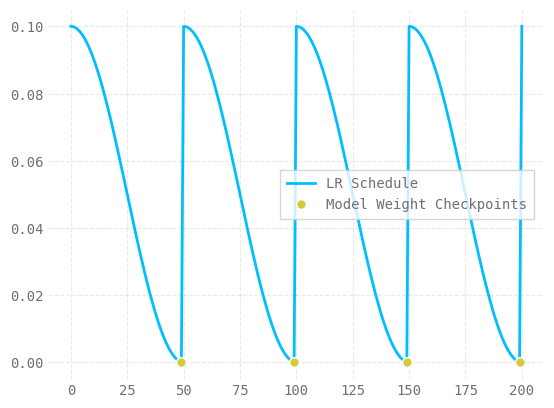

In [19]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=50, T_mult=1, eta_min=0)

lrs = []
epochs = 200

for i in range(epochs + 1):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(range(0, 201), lrs, label="LR Schedule")
plt.plot(range(49, 200, 50), [0.0]*4, 'o', label="Model Weight Checkpoints")
plt.legend()
plt.show()